## Лабораторная работа №2. Методы стеганоанализа
Выполнили:
- Килбас И.А., группа 6231-010402D
- Мухин А.В., группа 6233-010402D

## Вариант
- НЗБ встраивание {запись по псевдослучайным координатам}, {1 битовая плоскость}. Релевантные функции:
    - `get_1_binary_plane`, `insert_noise`
- Собственный набор признаков. Используются отсчеты дискретного преобразования Фурье. Релевантные функции:
    - `extract_features`


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler

import re
import os

SEED = 321

In [35]:
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [36]:
def load_data(q):
    X = np.load(f'features_data/features_{q}.npy')
    Y = np.load(f'features_data/labels_{q}.npy')

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=SEED)
    return X_train, X_test, y_train, y_test

In [37]:
experiment_model_selection = [
    (LogisticRegression, { "max_iter": 1000, "solver": 'lbfgs' }),
    (LogisticRegression, { "max_iter": 1000, "solver": 'liblinear' }),
    (LogisticRegression, { "max_iter": 1000, "solver": 'saga' }),
    (GaussianNB, {}),
    (DecisionTreeClassifier, { "criterion": "gini" }),
    (DecisionTreeClassifier, { "criterion": "entropy" }),
    (DecisionTreeClassifier, { "criterion": "log_loss" }),
    (PassiveAggressiveClassifier, { "max_iter": 1000, "C": 1.0}),
    (LinearDiscriminantAnalysis, {}),
    (SVC, { "kernel": "linear" }),
    (SVC, { "kernel": "poly" }),
    (SVC, { "kernel": "rbf" }),
    (KNeighborsClassifier, { "n_neighbors": 2 }),
    (KNeighborsClassifier, { "n_neighbors": 4 }),
    (KNeighborsClassifier, { "n_neighbors": 8 }),
    (KNeighborsClassifier, { "n_neighbors": 16 }),
    (MLPClassifier, { "hidden_layer_sizes": (64, ) }),
    (MLPClassifier, { "hidden_layer_sizes": (128, ) }),
    (MLPClassifier, { "hidden_layer_sizes": (256, ) }),
    (MLPClassifier, { "hidden_layer_sizes": (16, 16) }),
    (MLPClassifier, { "hidden_layer_sizes": (32, 32) }),
    (MLPClassifier, { "hidden_layer_sizes": (16, 32, 16) }),
    (MLPClassifier, { "hidden_layer_sizes": (64, 32, 16) }),
    (MLPClassifier, { "hidden_layer_sizes": (32, 32, 32) }),
    (MLPClassifier, { "hidden_layer_sizes": (16, 32, 32, 16) }),
    (MLPClassifier, { "hidden_layer_sizes": (32, 64, 64, 32) }),
    (MLPClassifier, { "hidden_layer_sizes": (128, 64, 64, 32) }),
]

In [38]:
def beautify_model_name(name):
    return re.findall(r"\.\w+", name)[-1][1:]

def test_model_with_params(X_train, X_test, y_train, y_test, model, params):
    model_instance = model(**params)
    model_instance = model_instance.fit(X_train, y_train)
    return model_instance.predict(X_train), model_instance.predict(X_test)

def experiment_runner(X_train, X_test, y_train, y_test):
    results = []
    for model, params in experiment_model_selection:
        print('Running', str(model), 'with parameters', str(params))
        preds_train, preds_test = test_model_with_params(X_train, X_test, y_train, y_test, model, params)
        metrics_train = (accuracy_score(y_train, preds_train), f1_score(y_train, preds_train, average='binary'))
        metrics_test = (accuracy_score(y_test, preds_test), f1_score(y_test, preds_test, average='binary'))
        results.append((f'{beautify_model_name(str(model))} {params}', {'train': metrics_train, 'test': metrics_test}))
    return results

In [39]:
columns = pd.MultiIndex.from_product([['train', 'test'], ['accuracy', 'f1score']])
index = [f'{beautify_model_name(str(name))} {params}' for name, params in experiment_model_selection]

def make_dataframe(r):
    x = [np.concatenate([v[:3] for k, v in single_measurement.items()]) for name, single_measurement in r]
    index = [name for name, single_measurement in r]
    df = pd.DataFrame.from_records(x, index=index, columns=columns).sort_values(by=[('test', 'accuracy')], ascending=False)
    return df

In [40]:
%%capture 
# Line above was added just to prevent any output
dfs = []
qs = [0.2, 0.4, 0.6, 0.8, 1.0]

for q in qs:
    data = load_data(q)
    r = experiment_runner(*data)
    df = make_dataframe(r)
    df.to_csv(os.path.join('results', f'q={q}.csv'))
    dfs.append(df)

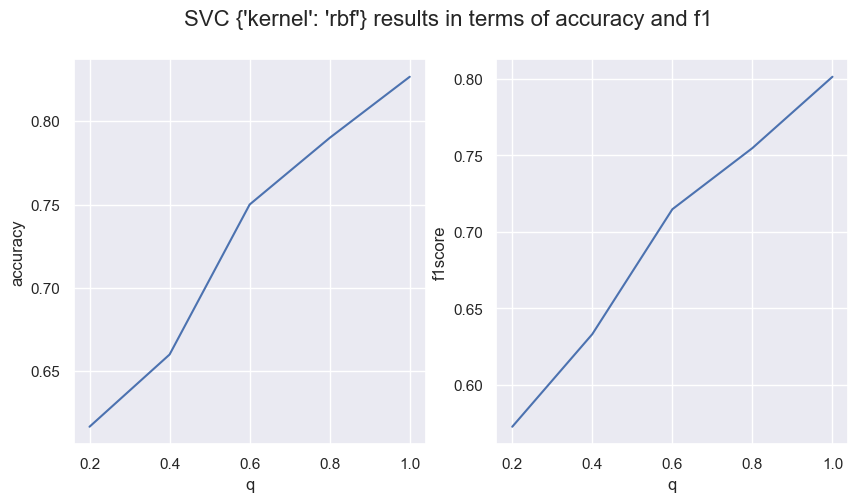

In [41]:
selected_model = "SVC {'kernel': 'rbf'}"
selected_model_results = pd.DataFrame(columns=['q', 'accuracy', 'f1score'])

for idx, (df, q) in enumerate(zip(dfs, qs)):
    row = df.loc[selected_model]
    row['test', 'q'] = q
    selected_model_results.loc[idx] = row['test']

sns.set_theme()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f"{selected_model} results in terms of accuracy and f1", fontsize=16)
sns.lineplot(selected_model_results, x="q", y='accuracy', ax=ax1)
sns.lineplot(selected_model_results, x="q", y='f1score', ax=ax2)
fig.savefig(os.path.join('results', 'models_result.png'))

# Working zone

In [7]:
X_train, X_test, y_train, y_test = load_data(q=0.6)

## Logistic regression

In [8]:
model = LogisticRegression(max_iter=1000, solver='lbfgs').fit(X_train, y_train)
preds = model.predict(X_test)

In [9]:
# Seems to be working
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.67      0.75      0.71       154
           1       0.70      0.62      0.65       146

    accuracy                           0.68       300
   macro avg       0.69      0.68      0.68       300
weighted avg       0.68      0.68      0.68       300



## MLP

In [10]:
model = MLPClassifier(
        max_iter=1_000,
        hidden_layer_sizes=(16, 32, 32, 16),
        learning_rate_init=0.001
    ).fit(X_train, y_train)
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)

In [11]:
print(classification_report(y_train, preds_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       346
           1       1.00      1.00      1.00       354

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700



In [12]:
print(classification_report(y_test, preds_test))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70       154
           1       0.69      0.62      0.65       146

    accuracy                           0.68       300
   macro avg       0.68      0.68      0.68       300
weighted avg       0.68      0.68      0.68       300



## Bayes

In [13]:
model = GaussianNB().fit(X_train, y_train)
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)

In [14]:
print(classification_report(y_train, preds_train))

              precision    recall  f1-score   support

           0       0.56      0.95      0.70       346
           1       0.85      0.27      0.40       354

    accuracy                           0.60       700
   macro avg       0.70      0.61      0.55       700
weighted avg       0.70      0.60      0.55       700



In [15]:
print(classification_report(y_test, preds_test))

              precision    recall  f1-score   support

           0       0.57      0.97      0.72       154
           1       0.89      0.23      0.36       146

    accuracy                           0.61       300
   macro avg       0.73      0.60      0.54       300
weighted avg       0.73      0.61      0.54       300



In [16]:
model = DecisionTreeClassifier().fit(X_train, y_train)
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)

In [17]:
print(classification_report(y_test, preds_test))

              precision    recall  f1-score   support

           0       0.65      0.66      0.65       154
           1       0.63      0.62      0.63       146

    accuracy                           0.64       300
   macro avg       0.64      0.64      0.64       300
weighted avg       0.64      0.64      0.64       300



## CNN

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pytorch_lightning as pl

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, 6, 5)
        self.bn1 = nn.BatchNorm1d(6)
        self.conv2 = nn.Conv1d(6, 16, 5)
        self.bn2 = nn.BatchNorm1d(16)
        self.fc1 = nn.Linear(1920, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x)) 
        x = self.bn1(x)
        x = F.relu(self.conv2(x)) 
        x = self.bn2(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return torch.flatten(x)

In [20]:
# Sanity check
Net()(torch.zeros((2, 1, 128)))

tensor([0.0908, 0.0908], grad_fn=<ReshapeAliasBackward0>)

In [26]:
class LightningModule(pl.LightningModule):
    def __init__(self, model, loss, lr=1e-3, T_0=10, T_mult=2):
        super().__init__()
        self.model = model
        self.lr = lr
        self.T_0 = T_0
        self.T_mult = T_mult
        self.loss = loss

    def forward(self, x):
        out = self.model(x)
        return out

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        signal, label = batch
        return self(signal)

    def validation_step(self, batch, batch_idx):
        signal, label = batch
        preds = torch.sigmoid(self(signal)) > 0.5
        return f1_score(preds.cpu().numpy(), label.cpu().numpy())

    def validation_epoch_end(self, outputs):
        print(np.mean(outputs))

    def configure_optimizers(self):
        print(f'Init optimizer with params: lr={self.lr}, T_0={self.T_0}, T_mult={self.T_mult}')
        optimizer = optim.Adam( 
            self.parameters(), lr=self.lr
        )

        lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, 
            T_0=self.T_0, T_mult=self.T_mult, eta_min=0
        )
        return { "optimizer": optimizer, "lr_scheduler": lr_scheduler }

    def training_step(self, train_batch, batch_idx):
        signal, label = train_batch
        preds = self.model(signal)
        loss = self.loss(preds, label)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss


In [27]:
train_datset = [(f, l) for f, l in zip(X_train[::, np.newaxis, ::], y_train.astype(np.float32))]
train_dataloader = torch.utils.data.DataLoader(train_datset, batch_size=64)

test_datset = [(f, l) for f, l in zip(X_test[::, np.newaxis, ::], y_test.astype(np.float32))]
test_dataloader = torch.utils.data.DataLoader(test_datset, batch_size=64)

In [28]:
net = Net()
loss = nn.BCEWithLogitsLoss()
model = LightningModule(net, loss, lr=1e-3)
trainer = pl.Trainer(max_epochs=100, devices=1, accelerator="gpu")
trainer.fit(model=model, train_dataloaders=train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\artem\miniconda3\envs\default\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | Net               | 533 K 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
533 K     Trainable params
0         Non-trainable params
533 K     Total params
2.134     Total estimated model params size (MB)


Init optimizer with params: lr=0.001, T_0=10, T_mult=2


c:\Users\artem\miniconda3\envs\default\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\artem\miniconda3\envs\default\lib\site-packages\pytorch_lightning\trainer\trainer.py:1558: PossibleUserWarning: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [29]:
trainer.validate(model, test_dataloader), trainer.validate(model, train_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\artem\miniconda3\envs\default\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


0.6723922029006776


c:\Users\artem\miniconda3\envs\default\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

1.0


([{}], [{}])